In [18]:
import datasets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
import os
import tiktoken
from src.utils.git_utils import get_changed_files_between_commits, get_repo_content_on_commit, parse_changed_files_and_lines_from_diff

In [19]:
!pip3 install tiktoken

# Bug localization datasets metrics

In [20]:
REPOS_PATH = '/Users/Maria.Tigina/PycharmProjects/lca-baselines/data/lca-bug-localization/repos'

In [21]:
dfs = {
    categoty: datasets.load_dataset(
        'JetBrains-Research/lca-bug-localization', 
        categoty,
        split='test',
        ignore_verifications=True,
        cache_dir='.'
    )
    for categoty in ['py', 'java', 'kt']
}

/Users/Maria.Tigina/PycharmProjects/lca-baselines/bug_localization/venv/lib/python3.10/site-packages/datasets/load.py:2096: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating dev split:   0%|          | 0/3146 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/21 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating dev split:   0%|          | 0/1059 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating dev split:   0%|          | 0/173 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [22]:
len(dfs['py'])

21

In [23]:
def _get_changed_lines(file_name: str, changed_lines: list[tuple, tuple], content: dict[str, str]):
    if file_name not in content:
        return []
    file_lines = content[file_name].split('\n')
    changed_lines_content = []
    
    for before, after in changed_lines:
        changed_lines_content += file_lines[before[0] - 1: before[0] + before[1] - 1]
        
    return changed_lines_content
    
def count_changed_symbols(content: dict[str, str], changed_files_and_lines: dict[str, list[tuple, tuple]]):
    return sum(len('\n'.join(_get_changed_lines(file_name, changed_lines, content)))
               for file_name, changed_lines in changed_files_and_lines.items())

def count_changed_tokens(content: dict[str, str], changed_files_and_lines: dict[str, list[tuple, tuple]]):
    tokenizer = tiktoken.encoding_for_model('gpt-4')
    return sum(len(tokenizer.encode('\n'.join(_get_changed_lines(file_name, changed_lines, content))))
               for file_name, changed_lines in changed_files_and_lines.items())

def count_changed_lines(content: dict[str, str], changed_files_and_lines: dict[str, list[tuple, tuple]]):
    return sum(len(_get_changed_lines(file_name, changed_lines, content)) for file_name, changed_lines in changed_files_and_lines.items())


def count_symbols(content: dict[str, str]):
    return sum([len(content) for content in content.values()])

def count_tokens(content: dict[str, str]):
    tokenizer = tiktoken.encoding_for_model('gpt-4')
    return sum([len(tokenizer.encode(content)) for content in content.values()])
    
def count_lines(content: dict[str, str]):
    return sum(len(content.split('\n')) for content in content.values())

In [24]:
def add_stats(dp, categoty):
    repo_path = os.path.join(REPOS_PATH, f"{dp['repo_owner']}__{dp['repo_name']}")
    repo_content = get_repo_content_on_commit(repo_path, dp["base_sha"], extensions=[categoty], ignore_tests = True)
    changed_files_and_lines = parse_changed_files_and_lines_from_diff(dp['diff'])
    
    dp['repo_symbols_count'] = count_symbols(repo_content)
    dp['repo_tokens_count'] = count_tokens(repo_content)
    dp['repo_lines_count'] = count_lines(repo_content)
    dp['repo_files_without_tests_count'] = len(repo_content)
    
    dp['changed_symbol_count'] = count_changed_symbols(repo_content, changed_files_and_lines)
    dp['changed_tokens_count'] = count_changed_tokens(repo_content, changed_files_and_lines)
    dp['changed_lines_count'] = count_changed_lines(repo_content, changed_files_and_lines)
    dp['changed_files_without_tests_count'] = len([f for f, _ in changed_files_and_lines.items() if f in repo_content])

    return dp

In [25]:
dp_stats = add_stats(dfs['java'][-2], 'java')
dp_stats

{'id': 78,
 'repo_owner': 'citrusframework',
 'repo_name': 'citrus',
 'issue_url': 'https://github.com/citrusframework/citrus/issues/418',
 'pull_url': 'https://github.com/citrusframework/citrus/pull/488',
 'comment_url': 'https://github.com/citrusframework/citrus/issues/418#issuecomment-424622238',
 'links_count': 1,
 'issue_title': 'Thread leak in TestCase.finish()',
 'issue_body': 'Hello,\r\n\r\nI am using citrus in an automatic testing tool executing test cases every 5 minutes (in the same JVM). \r\n\r\nFollowing an upgrade from 2.6.2 to 2.7.4 I noticed a thread leak.\r\nInvestigations showed that it might be located in [`com.consol.citrus.TestCase::finish`](https://github.com/citrusframework/citrus/blob/master/modules/citrus-core/src/main/java/com/consol/citrus/TestCase.java#L255). \r\n\r\nIt appears that the `ScheduledExecutorService` created by `Executors.newSingleThreadScheduledExecutor()` still hold the thread until the [`shutdown`](https://docs.oracle.com/javase/8/docs/api/ja

In [40]:
dfs_stats['java'][9]

{'id': 145,
 'repo_owner': 'swagger-api',
 'repo_name': 'swagger-core',
 'issue_url': 'https://github.com/swagger-api/swagger-core/issues/1578',
 'pull_url': 'https://github.com/swagger-api/swagger-core/pull/1571',
 'comment_url': 'https://github.com/swagger-api/swagger-core/pull/1571#issuecomment-166891241',
 'links_count': 2,
 'issue_title': 'byte and binary properties are wrong',
 'issue_body': 'It looks like these two commits are backwards:\n\nAddition of `binary` property:\nhttps://github.com/swagger-api/swagger-core/commit/a18409eb69d9c69435bb2f0bbec7b2540b46616d\n\nAddition of `byte` property:\nhttps://github.com/swagger-api/swagger-core/commit/4e7a8014d14a8d0dd54f31f825858ae072be1061\n',
 'base_sha': '084a34f3db106a09f8754516c9899b8a39a544f4',
 'head_sha': '4e7a8014d14a8d0dd54f31f825858ae072be1061',
 'diff_url': 'https://github.com/swagger-api/swagger-core/compare/084a34f3db106a09f8754516c9899b8a39a544f4...4e7a8014d14a8d0dd54f31f825858ae072be1061',
 'diff': 'diff --git a/module

In [32]:
dfs_stats = {
    category: dfs[category].map(lambda dp: add_stats(dp, category)) for category in ['py', 'kt', 'java']
}

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_dist(column: str, xlim, bins):
    plt.figure(figsize=(9, 5))
    data = []
    for i, category in enumerate(dfs_stats.keys()):
        # plt.subplot(3, 1, i + 1)
        data += dfs_stats[category][column]
    plt.hist(data, bins=bins)
    plt.xlim(xlim)
    plt.ylabel(category)
    print(category)
    print('max: ', np.max(data))
    print('min: ', np.min(data))
    print('avg:', np.mean(data))
    plt.xlabel(column)
    plt.show()

java
max:  321
min:  0
avg: 42.55555555555556


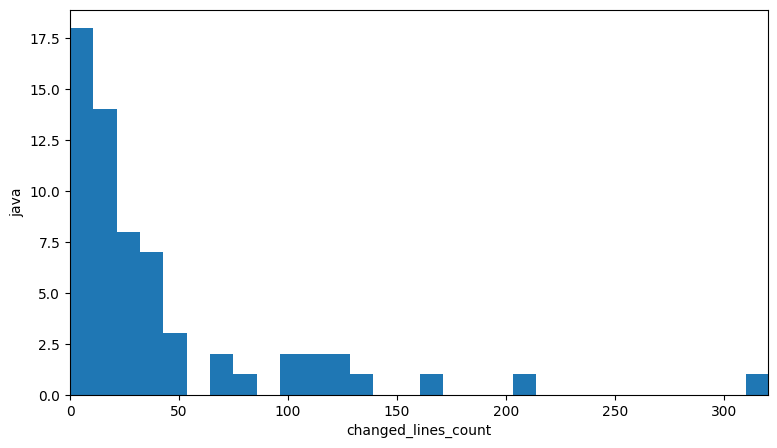

In [49]:
plot_dist('changed_lines_count', [0, 320], 30)

java
max:  401323
min:  195
avg: 63992.031746031746


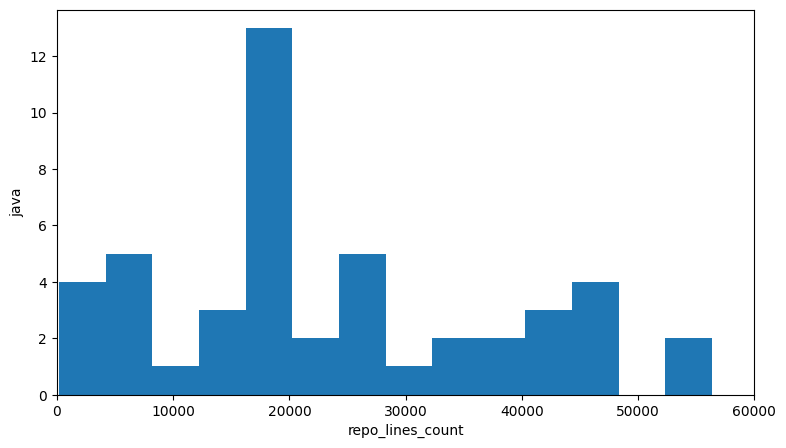

In [50]:
plot_dist('repo_lines_count', [0, 60000], 100)

java
max:  2875
min:  2
avg: 473.42857142857144


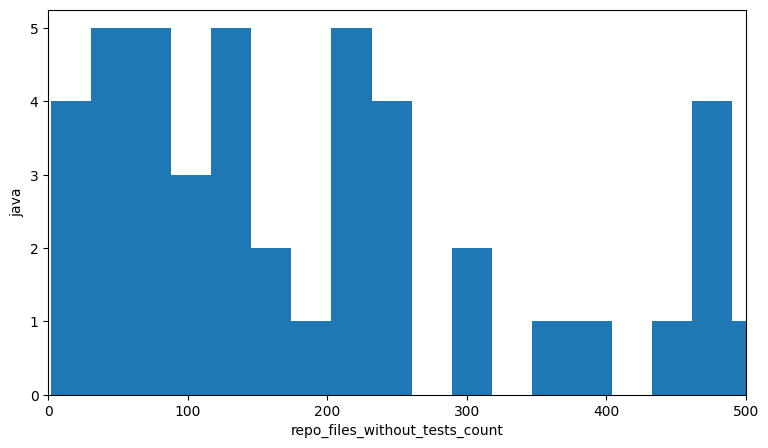

In [51]:
plot_dist('repo_files_without_tests_count', [0, 500], 100)

java
max:  15
min:  0
avg: 2.0


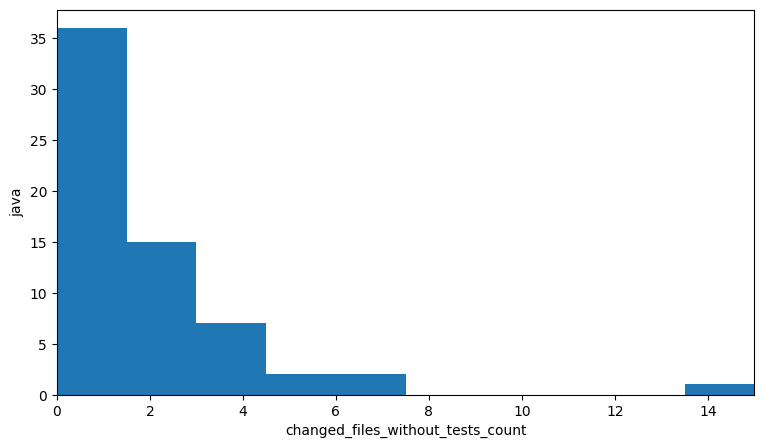

In [52]:
plot_dist('changed_files_without_tests_count', [0, 15], 10)

java
max:  3364325
min:  1125
avg: 575537.3174603175


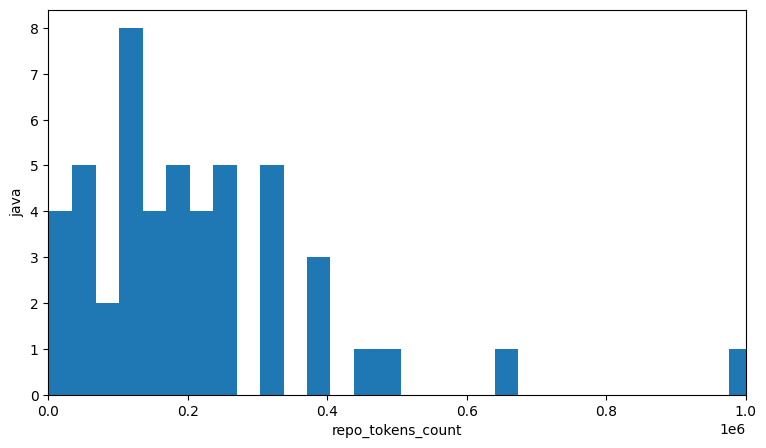

In [61]:
plot_dist('repo_tokens_count', [0, 1000000], 100)

java
max:  2307
min:  0
avg: 333.6507936507937


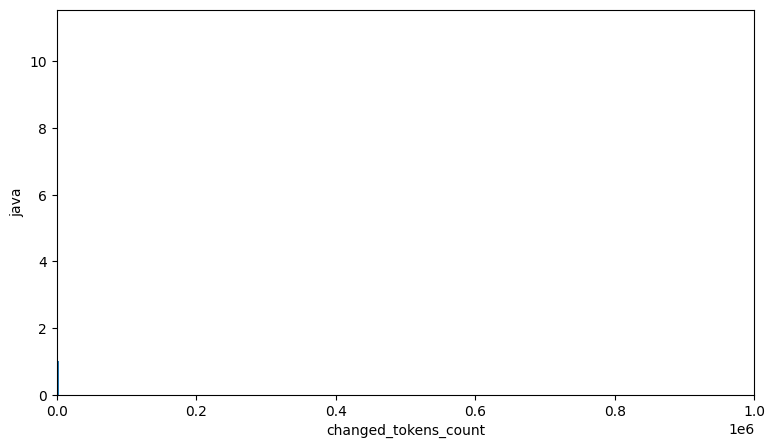

In [63]:
plot_dist('changed_tokens_count', [0, 1000000], 100)